In [1]:
import math

import fresnel
import freud
import gsd.hoomd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


OPENMP DISPLAY ENVIRONMENT BEGIN
   _OPENMP='201611'
  [host] OMP_AFFINITY_FORMAT='OMP: pid %P tid %i thread %n bound to OS proc set {%A}'
  [host] OMP_ALLOCATOR='omp_default_mem_alloc'
  [host] OMP_CANCELLATION='FALSE'
  [host] OMP_DEFAULT_DEVICE='0'
  [host] OMP_DISPLAY_AFFINITY='FALSE'
  [host] OMP_DISPLAY_ENV='TRUE'
  [host] OMP_DYNAMIC='FALSE'
  [host] OMP_MAX_ACTIVE_LEVELS='1'
  [host] OMP_MAX_TASK_PRIORITY='0'
  [host] OMP_NESTED: deprecated; max-active-levels-var=1
  [host] OMP_NUM_THREADS: value is not defined
  [host] OMP_PROC_BIND='false'
  [host] OMP_SCHEDULE='static'
  [host] OMP_STACKSIZE='8M'
  [host] OMP_TARGET_OFFLOAD=DEFAULT
  [host] OMP_THREAD_LIMIT='2147483647'
  [host] OMP_TOOL='enabled'
  [host] OMP_TOOL_LIBRARIES: value is not defined
  [host] OMP_TOOL_VERBOSE_INIT: value is not defined
  [host] OMP_WAIT_POLICY='PASSIVE'
OPENMP DISPLAY ENVIRONMENT END




In [2]:
# All are in units of angstroms
pitch = 5.4
Radius = 2.3
bead_size = 1.0
translation_per_residue = 1.5
aa_per_turn = 3.6
Naa = 18.0 # Number of amino acids in the chain
total_length = Naa * translation_per_residue

print("total length: {}".format(total_length))

total length: 27.0


In [3]:
# Derived units for our helix
a = Radius
b = pitch / (2*np.pi)
curvature = np.abs(Radius)/(Radius**2 + b**2)
tspace_guess = 2.0 / np.sqrt(Radius**2 + b**2) / curvature * np.arcsin(curvature*bead_size / 2.0)

# Positions in both t and s space
def helix_position(a, b, t):
    return np.array([a*np.cos(t), a*np.sin(t), b*t], dtype=np.float64)
def helix_position_s(a, b, s):
    return np.array([a*np.cos(s/np.sqrt(a**2 + b**2)), a*np.sin(s/np.sqrt(a**2 + b**2)), b*s/np.sqrt(a**2 + b**2)])

from scipy.optimize import fsolve
def space_func(t0, a, b, d):
    return 4.0 * np.square(a) * np.square(np.sin(t0/2.0)) + np.square(b*t0) - np.square(d)
def space_func_s(s, a, b, d):
    return 4.0 * np.square(a*np.sin(s/(2.0*np.sqrt(a**2 + b**2)))) + np.square(b*s/np.sqrt(a**2 + b**2)) \
        - np.square(d)

tspace_root = fsolve(space_func, tspace_guess, args=(a, b, bead_size))
sspace_root = fsolve(space_func_s, 1.0, args=(a, b, bead_size))

#print(a)
#print(b)
#print(curvature)
print("tspace_guess: {}".format(tspace_guess))
print("tspace_root:  {}".format(tspace_root[0]))
t_root = tspace_root[0]

# What even are our first helix positions?
print("arclength(guess): {}".format(np.sqrt(a**2 + b**2)*tspace_guess))
print("arclength(r00t):  {}".format(np.sqrt(a**2 + b**2)*tspace_root[0]))
print("position0:        {}".format(helix_position(a, b, 0.0)))
print("position1(guess): {}".format(helix_position(a, b, tspace_guess)))
print("position1(root):  {}".format(helix_position(a, b, tspace_root[0])))
print("position1(s0):    {}".format(helix_position_s(a, b, sspace_root[0])))

# How close are we to having a distance between points of 1?
dr_guess = np.linalg.norm(helix_position(a, b, tspace_guess) - helix_position(a, b, 0.0))
dr_root = np.linalg.norm(helix_position(a, b, tspace_root[0]) - helix_position(a, b, 0.0))

print("t_guess: {}, dr: {}".format(tspace_guess, dr_guess))
print("t_root:  {}, dr: {}".format(tspace_root[0], dr_root))

# Calculate the number of beads from the total Z size
Nbeads = np.int64(total_length / (t_root * b))
print(f"Nbeads(from t_root): {Nbeads}")

tspace_guess: 0.4097890490715006
tspace_root:  0.4097872904270373
arclength(guess): 1.0061661792284915
arclength(r00t):  1.0061618611809882
position0:        [2.3 0.  0. ]
position1(guess): [2.10957125 0.91635646 0.35218775]
position1(root):  [2.10957286 0.91635275 0.35218623]
position1(s0):    [2.10957286 0.91635275 0.35218623]
t_guess: 0.4097890490715006, dr: 1.0000042388482662
t_root:  0.4097872904270373, dr: 1.0
Nbeads(from t_root): 76


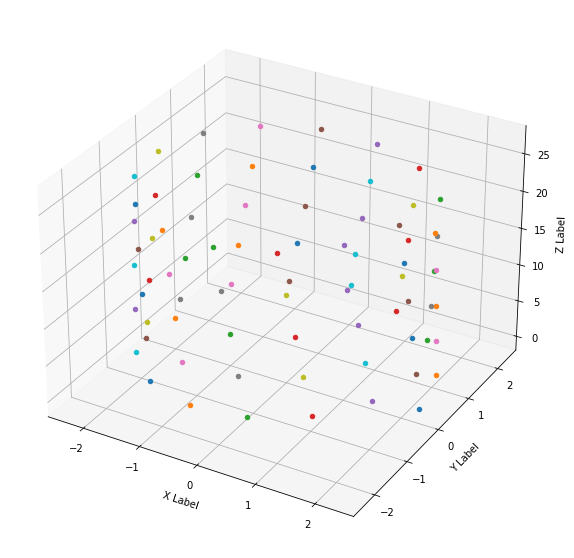

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for tdx in np.linspace(0.0, Nbeads*t_root, Nbeads):
    r = helix_position(Radius, b, tdx)
    ax.scatter(r[0], r[1], r[2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [5]:
# Calculate the angle between the three points
r01 = helix_position(Radius, b, t_root) - helix_position(Radius, b, 0.0)
r12 = helix_position(Radius, b, 2.0*t_root) - helix_position(Radius, b, t_root)
theta0 = np.arccos(np.dot(r01, r12)/np.linalg.norm(r01)/np.linalg.norm(r12))
print(f"Theta0: {np.pi - theta0}")

Theta0: 2.758398187954275
